### Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/Challenge2

/gdrive/My Drive/Challenge2


In [ ]:
ls

 1DNN.ipynb                                     LSTM.ipynb
 BiLSTM.ipynb                                   training_dataset_homework2/
'Copia di 7) Timeseries Classification.ipynb'


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [37]:
# Random seed for reproducibility
seed = 46

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)
#### Human Activity Recognition

Load and clean the dataset

In [6]:
x_train= np.load("training_dataset_homework2/x_train.npy")
y_train= np.load("training_dataset_homework2/y_train.npy")

In [7]:
x_train.shape

(2429, 36, 6)

In [8]:
y_train.shape

(2429,)

### Preprocessing

Split, Encode and Normalize

In [9]:
# Map activities to integers
label_mapping = {
     "Wish": 0,
      "Another": 1,
"Comfortably": 2,
"Money": 3,
"Breathe":4,
 "Time":5,
 "Brain":6,
 "Echoes":7,
"Wearing":8,
"Sorrow":9,
"Hey":10,
 "Shine":11
}


In [10]:
x_mean = x_train.mean()
x_mean

25.295960919260704

In [11]:
x_std = x_train.std()
x_std

658.4301638513654

In [12]:
#x_train = (x_train - x_mean) / x_std

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=seed, test_size=.1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2186, 36, 6), (2186,), (243, 36, 6), (243,))

In [14]:
'''
# train
for i in range(x_train.shape[0]):
  transformer = RobustScaler().fit(x_train[i])
  x_train[i] = transformer.transform(x_train[i])

#test
for i in range(x_test.shape[0]):
  transformer = RobustScaler().fit(x_test[i])
  x_test[i] = transformer.transform(x_test[i])
'''

'\n# train\nfor i in range(x_train.shape[0]):\n  transformer = RobustScaler().fit(x_train[i])\n  x_train[i] = transformer.transform(x_train[i])\n\n#test\nfor i in range(x_test.shape[0]):\n  transformer = RobustScaler().fit(x_test[i])\n  x_test[i] = transformer.transform(x_test[i])\n'

In [15]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
x_train.shape, y_train.shape, y_test.shape, y_test.shape

((2186, 36, 6), (2186, 12), (243, 12), (243, 12))

### Build and train models

In [16]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 512
epochs = 200

Damn, once again no free lunch

### MIX

In [73]:
def build_mix_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #1D
    cnn = tfkl.Conv1D(1024,3,padding='same')(input_layer)
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same')(cnn)
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    #gap = tfkl.GlobalAveragePooling1D()(cnn)
    #dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    #classifier = tfkl.Dense(128, activation='relu')(dropout)

    #LSTM
    lstm = tfkl.Bidirectional(tfkl.LSTM(1024, return_sequences=True))(cnn)
    #lstm = tfkl.LSTM(128, return_sequences=True)(cnn)
    lstm = tfkl.Bidirectional(tfkl.LSTM(256))(lstm)
    #dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    #classifier = tfkl.Dense(128, activation='relu')(dropout)

    # Classifier
    classifier = tfkl.Dense(1024)(lstm)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    classifier = tfkl.Dense(512)(classifier)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    classifier = tfkl.Dense(256)(classifier)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [74]:
model = build_mix_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 36, 1024)          19456     
                                                                 
 p_re_lu_16 (PReLU)          (None, 36, 1024)          36864     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 18, 1024)         0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 18, 512)           1573376   
                                                                 
 p_re_lu_17 (PReLU)          (None, 18, 512)           9216      
                                                             

In [75]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
4/4 [==============================] - 8s 698ms/step - loss: 2.4433 - accuracy: 0.1998 - val_loss: 2.0964 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 1s 262ms/step - loss: 2.0987 - accuracy: 0.3127 - val_loss: 2.0458 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 1.9303 - accuracy: 0.3808 - val_loss: 1.8782 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 1s 240ms/step - loss: 1.8154 - accuracy: 0.4042 - val_loss: 1.8686 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 1s 266ms/step - loss: 1.7494 - accuracy: 0.4174 - val_loss: 1.8262 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 1s 272ms/step - loss: 1.6872 - accuracy: 0.4347 - val_loss: 1.7114 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 7/200
4/4 [==============================] - 1s 238ms/step - loss: 1.6

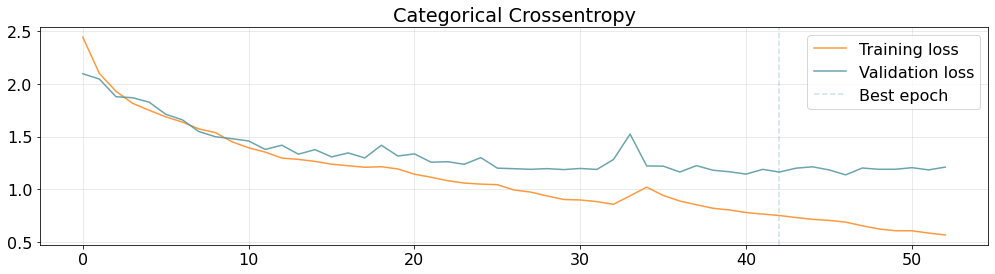

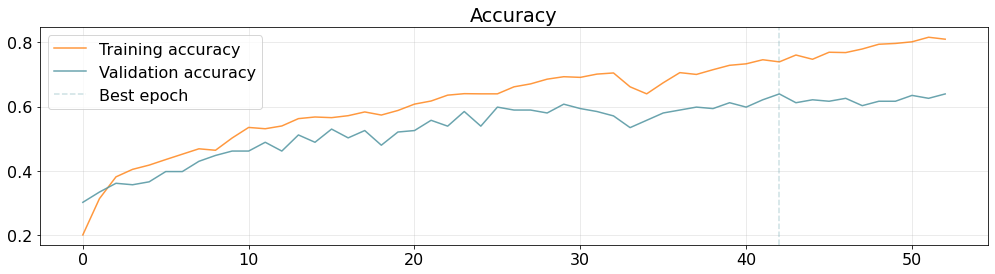

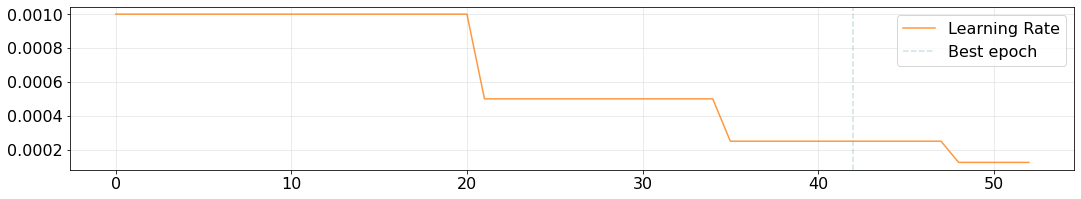

In [76]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [77]:
# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
predictions.shape

8/8 [==============================] - 1s 15ms/step


(243, 12)

Accuracy: 0.7202
Precision: 0.5255
Recall: 0.5551
F1: 0.5336


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


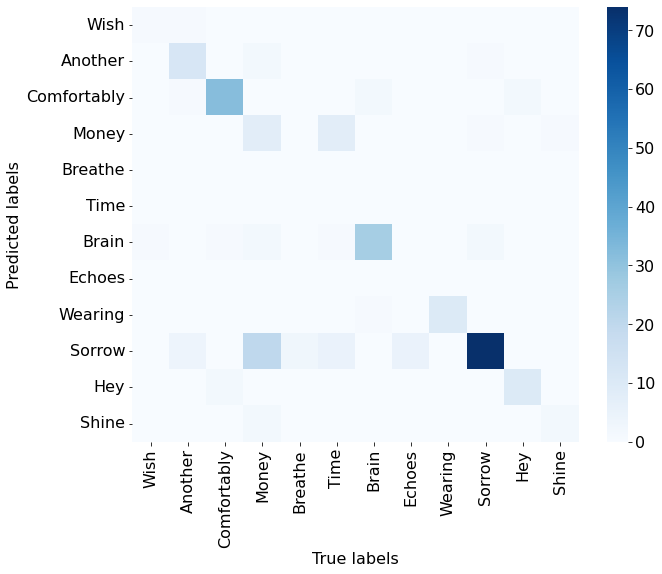

In [78]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [79]:
model.save('MIX_2')
# model = tfk.models.load_model('1DCNN')